In [ ]:
## 참고!
## False Positive = 0을 1로 예측한 경우 = 최적 입지 인데 FN으로 착각하여 표기했습니다.

In [35]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import os
import time

# 지도 데이터 분석 라이브러리
import fiona
import geopandas

# 데이터 분석 라|이브러리
import pandas as pd
import numpy as np

# 데이터 시각화 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import style
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import fontawesomefree as fa
import pydeck

# 데이터 분리
from sklearn.model_selection import train_test_split

# 데이터 스케일링
from sklearn.preprocessing import MinMaxScaler

# 데이터 샘플링
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# 머신러닝
import xgboost
import catboost
import lightgbm
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import ensemble
import optuna

# 모델 스코어링
from sklearn.metrics import f1_score

In [36]:
# matplotlib 한글 지원 폰트 설정
plt.rc("font", family="Malgun Gothic")

In [37]:
# 데이터 불러오기

sejong = geopandas.read_file('./dataset/전처리후/세종/merge_11.geojson', encoding='utf-8')
sejong = sejong[['geometry', 'lat', 'lng', '고저차', '인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '주차장수', '교육연구시설', '주거지', '농축산업시설', '창고시설',
       '편의시설', '생산시설', '님비시설', '자동차관련시설', 'EV']]

daegu = geopandas.read_file('./dataset/전처리후/대구/merge_11.geojson', encoding='utf-8')
daegu = daegu[['geometry', 'lat', 'lng', '고저차', '인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '주차장수', '교육연구시설', '주거지', '농축산업시설', '창고시설',
       '편의시설', '생산시설', '님비시설', '자동차관련시설', 'EV']]

daejeon = geopandas.read_file('./dataset/전처리후/대전/merge_11.geojson', encoding='utf-8')
daejeon = daejeon[['geometry', 'lat', 'lng', '고저차', '인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '주차장수', '교육연구시설', '주거지', '농축산업시설', '창고시설',
       '편의시설', '생산시설', '님비시설', '자동차관련시설', 'EV']]

In [38]:
# 인구수 = 0 & 충전소 = 0 인 타일 제거

sejong_pp = sejong.drop(sejong[(sejong['인구수']==0) & (sejong['EV']==0)].index)
daegu_pp = daegu.drop(daegu[(daegu['인구수']==0) & (daegu['EV']==0)].index)
daejeon_pp = daejeon.drop(daejeon[(daejeon['인구수']==0) & (daejeon['EV']==0)].index)

print('세종시 데이터 수 :', len(sejong))
print('세종시 인구수=0, 충전소=0인 타일:', len(sejong_pp), end='\n\n')

print('대전시 데이터 수 :', len(daejeon))
print('대전시 인구수=0인, 충전소=0인 타일:', len(daejeon_pp), end='\n\n')

print('대구시 데이터 수 :', len(daegu))
print('대구시 인구수=0인, 충전소=0인 타일:', len(daegu_pp))

sejong_pp_idx = sejong_pp.index

sejong_pp.reset_index(drop=True, inplace=True)
daejeon_pp.reset_index(drop=True, inplace=True)
daegu_pp.reset_index(drop=True, inplace=True)

세종시 데이터 수 : 47396
세종시 인구수=0, 충전소=0인 타일: 3391

대전시 데이터 수 : 58429
대전시 인구수=0인, 충전소=0인 타일: 8857

대구시 데이터 수 : 93612
대구시 인구수=0인, 충전소=0인 타일: 13107


In [39]:
# 정규화

scaler = MinMaxScaler()
sejong_pp_minmax = scaler.fit_transform(sejong_pp[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']])
sejong_pp_minmax = pd.DataFrame(sejong_pp_minmax, columns=['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차'])
sejong_pp[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']] = sejong_pp_minmax

daegu_pp_minmax = scaler.fit_transform(daegu_pp[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']])
daegu_pp_minmax = pd.DataFrame(daegu_pp_minmax, columns=['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차'])
daegu_pp[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']] = daegu_pp_minmax

daejeon_pp_minmax = scaler.fit_transform(daejeon_pp[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']])
daejeon_pp_minmax = pd.DataFrame(daejeon_pp_minmax, columns=['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차'])
daejeon_pp[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']] = daejeon_pp_minmax

In [40]:
# 학습 / 검증 데이터 셋 분리

train_data = pd.concat([daegu_pp[daegu_pp.columns[3:-1]], daejeon_pp[daejeon_pp.columns[3:-1]]])
train_target = pd.concat([daegu_pp[daegu_pp.columns[-1]], daejeon_pp[daejeon_pp.columns[-1]]])

test_data = sejong_pp[sejong_pp.columns[3:-1]]
test_target = sejong_pp[sejong_pp.columns[-1]]

test_data.set_index(sejong_pp_idx, inplace=True)

In [41]:
### 랜덤언더샘플링
rus = RandomUnderSampler()
train_data_rus, train_target_rus = rus.fit_resample(train_data, train_target)

### 랜덤오버샘플링
ros = RandomOverSampler()
train_data_ros, train_target_ros = ros.fit_resample(train_data, train_target)

### 스모트오버샘플링
smote = SMOTE()
train_data_smote, train_target_smote = smote.fit_resample(train_data, train_target)

## 하이퍼파라미터 튜닝 ( Optuna )

### RandomForest

In [23]:
def rf_optuna(train_data, train_target, test_data, test_target, threshold):
    def rf_objective(trial):
        
        params = {
                    'max_depth' : trial.suggest_int('max_depth', 1, 10),
                    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
                    'n_estimators' : trial.suggest_int('n_estimators', 100, 500),
                    "n_jobs": 4
            }

        clf = ensemble.RandomForestClassifier(**params, verbose=0)
        clf.fit(train_data, train_target)
        proba = clf.predict_proba(test_data)
        preds = (proba[:,1] >= threshold).astype('int')
        
        temp = sejong.copy()
        temp['pred'] = [0]*len(temp)
        for i, idx in enumerate(test_data.index):
            temp['pred'][idx] = preds[i]
        temp = select_EV(temp)

        f1 = f1_score(test_target, preds)

        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(rf_objective, n_trials=50, show_progress_bar=True)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")

    trial = study.best_trial

    print("  F1 : {}".format(trial.value))
    print("  Best hyperparameters: ")

    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    clf = ensemble.RandomForestClassifier(**study.best_params)
    clf.fit(train_data, train_target)
    preds = clf.predict(test_data)
    
    temp = sejong.copy()
    temp['pred'] = [0]*len(temp)
    for i, idx in enumerate(test_data.index):
        temp['pred'][idx] = preds[i]
    
    temp = select_EV(temp)
    f1 = f1_score(test_target, preds)
    
    return clf, temp, f1

### XGBoost

In [13]:
def xgb_optuna(train_data, train_target, test_data, test_target, threshold):
    def xgb_objective(trial):
        params = {
                #"objective": "multiclass",
                #"eval_metric":'mlogloss',
                "booster": 'gbtree',
                'tree_method':'gpu_hist', 'predictor':'gpu_predictor', 'gpu_id': 0, # GPU 사용시
                #"tree_method": 'exact', 'gpu_id': -1,  # CPU 사용시
                "n_jobs": 4,
                #"verbosity": 0,
                "max_depth": trial.suggest_int("max_depth", 4, 16),
                "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
                'n_estimators': trial.suggest_int("n_estimators", 1000, 10000, step=100),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
                "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
                "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
                "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1),
                #'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),     
                'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
                "gamma": trial.suggest_float("gamma", 0.1, 1.0, log=True),
                # 'num_parallel_tree': trial.suggest_int("num_parallel_tree", 1, 500) 추가하면 느려짐.
            }

        clf = xgboost.XGBClassifier(**params)
        clf.fit(train_data, train_target, verbose=0)
        proba = clf.predict_proba(test_data)
        preds = (proba[:,1] >= threshold).astype('int')
        
        temp = sejong.copy()
        temp['pred'] = [0]*len(temp)
        for i, idx in enumerate(test_data.index):
            temp['pred'][idx] = preds[i]
        temp = select_EV(temp)
        
        f1 = f1_score(test_target, preds)

        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(xgb_objective, n_trials=50, n_jobs=4, show_progress_bar=True)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")

    trial = study.best_trial

    print("  F1 : {}".format(trial.value))
    print("  Best hyperparameters: ")

    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    clf = xgboost.XGBClassifier(**study.best_params)
    clf.fit(train_data, train_target)
    preds = clf.predict(test_data)
    
    temp = sejong.copy()
    temp['pred'] = [0]*len(temp)
    for i, idx in enumerate(test_data.index):
        temp['pred'][idx] = preds[i]
    
    temp = select_EV(temp)
    f1 = f1_score(test_target, preds)
    
    return clf, temp, f1

### LightGBM

In [14]:
def lgbm_optuna(train_data, train_target, test_data, test_target, threshold):
    def lgbm_objective(trial):

        params = {
                #"objective": "multiclass",
                #"eval_metric":'mlogloss',
                "booster": 'gbtree',
                'tree_method':'gpu_hist', 'predictor':'gpu_predictor', 'gpu_id': 0, # GPU 사용시
                #"tree_method": 'exact', 'gpu_id': -1,  # CPU 사용시
                "n_jobs": 4,
                #"verbosity": 0,
                "max_depth": trial.suggest_int("max_depth", 4, 16),
                "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
                'n_estimators': trial.suggest_int("n_estimators", 1000, 10000, step=100),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
                "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
                "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
                "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1),
                #'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),     
                'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
                "gamma": trial.suggest_float("gamma", 0.1, 1.0, log=True),
                # 'num_parallel_tree': trial.suggest_int("num_parallel_tree", 1, 500) 추가하면 느려짐.
            }

        clf = lightgbm.LGBMClassifier(**params)
        clf.fit(train_data, train_target, verbose=0)
        proba = clf.predict_proba(test_data)
        preds = (proba[:,1] >= threshold).astype('int')
        
        temp = sejong.copy()
        temp['pred'] = [0]*len(temp)
        for i, idx in enumerate(test_data.index):
            temp['pred'][idx] = preds[i]
        temp = select_EV(temp)
        
        f1 = f1_score(test_target, preds)

        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(lgbm_objective, n_trials=50, n_jobs=4, show_progress_bar=True)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")

    trial = study.best_trial

    print("  F1 : {}".format(trial.value))
    print("  Best hyperparameters: ")

    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    clf = lightgbm.LGBMClassifier(**study.best_params)
    clf.fit(train_data, train_target)
    preds = clf.predict(test_data)
    
    temp = sejong.copy()
    temp['pred'] = [0]*len(temp)
    for i, idx in enumerate(test_data.index):
        temp['pred'][idx] = preds[i]
    
    temp = select_EV(temp)
    f1 = f1_score(test_target, preds)
    
    return clf, temp, f1

### CatBoost

In [15]:
def catb_optuna(train_data, train_target, test_data, test_target, threshold):
    def catb_objective(trial):

        params = {
        #"objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        'gpu_id':0,
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "n_jobs": 4,
        }


        clf = catboost.CatBoostClassifier(**params)
        clf.fit(train_data, train_target, verbose=0, early_stopping_rounds=100)
        proba = clf.predict_proba(test_data)
        preds = (proba[:,1] >= threshold).astype('int')
        
        temp = sejong.copy()
        temp['pred'] = [0]*len(temp)
        for i, idx in enumerate(test_data.index):
            temp['pred'][idx] = preds[i]
        temp = select_EV(temp)
        
        f1 = f1_score(test_target, preds)

        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(catb_objective, n_trials=50, n_jobs=4, show_progress_bar=True)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")

    trial = study.best_trial

    print("  F1 : {}".format(trial.value))
    print("  Best hyperparameters: ")

    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    clf = catboost.CatBoostClassifier(**study.best_params)
    clf.fit(train_data, train_target)
    preds = clf.predict(test_data)
    
    temp = sejong.copy()
    temp['pred'] = [0]*len(temp)
    for i, idx in enumerate(test_data.index):
        temp['pred'][idx] = preds[i]
    
    temp = select_EV(temp)
    f1 = f1_score(test_target, preds)
    
    return clf, temp, f1

## feature_importance

In [16]:
def feature_importance(clf):
    feature_importance = clf.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(test_data.columns)[sorted_idx])
    plt.title('Feature Importance')

## Arrange

In [17]:
def arrange(df):
    print('실제 충전소 수 :', len(df[df['EV']==1]))
    print('충전소가 있어야 한다고 분류한 타일 수 :', len(df[df['pred']==1]))
    print('recall score 실제 충전소가 맞는 지 맞춘 경우 :', len(df[(df['pred']==1) & (df['EV']==1)]), '/', len(df[df['EV']==1]))
    print('precision score 실제 충전소가 없는 곳을 맞춘 경우 :', len(df[(df['pred']==0) & (df['EV']==0)]), '/', len(df[df['EV']==0]))
    print('최적 입지 후보(실제론 없지만, 있어야 한다고 분류) :', len(df[(df['pred']==1) & (df['EV']==0)]), '/', len(df[df['EV']==0]))

## select_EV

In [18]:
def select_EV(df):
    df['FP'] = [0]*len(df)
    # EV == 0 & predict == 1 인 경우만 ['pred']에서 1로 설정
    idx = df[(df['EV'] == 0) & (df['pred'] == 1)].index
    for i in df[df['pred'] == 1].index:
        df['FP'].loc[i] = 0
    for i in idx:
        df['FP'].loc[i] = 1
        
    return df

## map_visualization

In [19]:
def map_visualization(df):
    fig, ax1 = plt.subplots(figsize=(15, 15))
    fig.set_facecolor('white')
    sejong['geometry'].plot(ax=ax1, color='gainsboro')
    sejong[sejong['EV']==1].plot(ax=ax1, column='EV', color='lime', aspect=1)
    df[df[df.columns[-1]]==1].plot(ax=ax1, column=df.columns[-1], color='red', aspect=1)
    ax1.set_axis_off()
    plt.show()

## 임계치 별 모델 학습

In [20]:
train_data_list = [train_data_rus, train_data_smote]
train_target_list = [train_target_rus, train_target_smote]

In [24]:
rf_F1 = [] # 0~9 : rus, 10~19 : ros, 20~29 : smote
rf_TP = [] # TrusPositive
rf_df = []
rf_clf = []
rf_FP = [] # FalsePositive = 최적입지

for i, (train_data, train_target) in enumerate(zip(train_data_list, train_target_list)):
    for threshold in np.arange(0.1, 1, 0.1):
        clear_output()
        print('threshold :', threshold, '(', i, ' 번째 데이터 )')
        clf, df, f1 = rf_optuna(train_data, train_target, test_data, test_target, threshold)
        clear_output()
        rf_F1.append(f1)
        rf_TP.append(len(df[(df['pred']==1) & (df['EV']==1)]))
        rf_df.append(df)
        rf_clf.append(clf)
        rf_FP.append(len(df[df['FP']==1]))

In [ ]:
# XGBoost는 시간이 너무 오래걸려서 제외

'''
xgb_F1 = [] # 0~9 : rus, 10~19 : ros, 20~29 : smote
xgb_TP = []
xgb_df = []
xgb_clf = []
xgb_FP = []

for i, (train_data, train_target) in enumerate(zip(train_data_list, train_target_list)):
    for threshold in np.arange(0.1, 1, 0.1):
        clear_output()
        print('threshold :', threshold, '(', i, ' 번째 데이터 )')
        clf, df, f1 = xgb_optuna(train_data, train_target, test_data, test_target, threshold)
        clear_output()
        xgb_F1.append(f1)
        xgb_TP.append(len(df[(df['pred']==1) & (df['EV']==1)]))
        xgb_df.append(df)
        xgb_clf.append(clf)
        xgb_FP.append(len(df[df['FP']==1]))
'''

In [ ]:
lgbm_F1 = [] # 0~9 : rus, 10~19 : ros, 20~29 : smote
lgbm_TP = []
lgbm_df = []
lgbm_clf = []
lgbm_FP = []
for i, (train_data, train_target) in enumerate(zip(train_data_list, train_target_list)):
    for threshold in np.arange(0.1, 1, 0.1):
        clear_output()
        print('threshold :', threshold, '(', i, ' 번째 데이터 )')
        clf, df, f1 = lgbm_optuna(train_data, train_target, test_data, test_target, threshold)
        clear_output()
        lgbm_F1.append(f1)
        lgbm_TP.append(len(df[(df['pred']==1) & (df['EV']==1)]))
        lgbm_df.append(df)
        lgbm_clf.append(clf)
        lgbm_FP.append(len(df[df['FP']==1]))

In [ ]:
catb_F1 = [] # 0~9 : rus, 10~19 : ros, 20~29 : smote
catb_TP = []
catb_df = []
catb_clf = []
catb_FP = []

for i, (train_data, train_target) in enumerate(zip(train_data_list, train_target_list)):
    for threshold in np.arange(0.1, 1, 0.1):
        clear_output()
        print('threshold :', threshold, '(', i, ' 번째 데이터 )')
        clf, df, f1 = catb_optuna(train_data, train_target, test_data, test_target, threshold)
        clear_output()
        catb_F1.append(f1)
        catb_TP.append(len(df[(df['pred']==1) & (df['EV']==1)]))
        catb_df.append(df)
        catb_clf.append(clf)
        catb_FP.append(len(df[df['FP']==1]))

## 모델 선정

### RandomForest

In [25]:
print(rf_F1)
print(rf_TP)
print(rf_FP)
rf_result = pd.DataFrame({'F1_score':rf_F1,
                            'TP':rf_TP,
                            'FP':rf_FP})
rf_result

[0.5959367945823928, 0.5906040268456375, 0.6082949308755761, 0.5986394557823128, 0.585812356979405, 0.6027397260273973, 0.5986394557823128, 0.5879732739420935, 0.6027397260273973, 0.6226415094339622, 0.619718309859155, 0.624113475177305, 0.6226415094339622, 0.6282973621103117, 0.6255924170616114, 0.624113475177305, 0.6226415094339622, 0.624113475177305]
[132, 132, 132, 132, 128, 132, 132, 132, 132, 132, 132, 132, 132, 131, 132, 132, 132, 132]
[35, 39, 26, 33, 33, 30, 33, 41, 30, 16, 18, 15, 16, 10, 14, 15, 16, 15]


F1_score   TP  FP
0   0.595937  132  35
1   0.590604  132  39
2   0.608295  132  26
3   0.598639  132  33
4   0.585812  128  33
5   0.602740  132  30
6   0.598639  132  33
7   0.587973  132  41
8   0.602740  132  30
9   0.622642  132  16
10  0.619718  132  18
11  0.624113  132  15
12  0.622642  132  16
13  0.628297  131  10
14  0.625592  132  14
15  0.624113  132  15
16  0.622642  132  16
17  0.624113  132  15

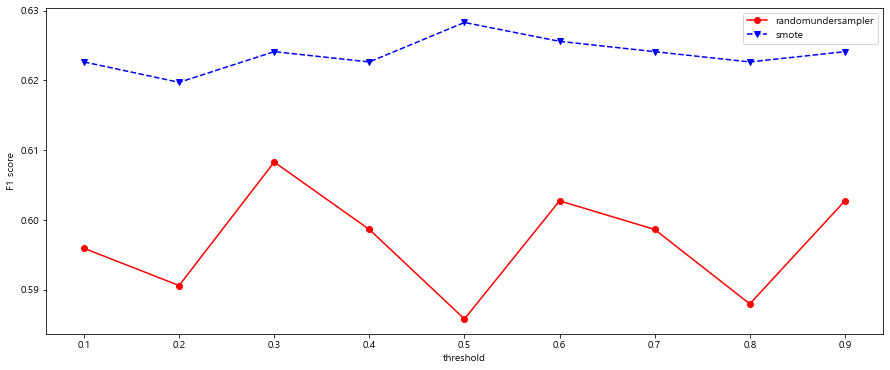

In [26]:
threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.figure(figsize=(15, 6))
plt.plot(threshold, rf_result['F1_score'][:9].to_list(), 'ro-', threshold, rf_result['F1_score'][9:].to_list(), 'bv--')
plt.legend(['randomundersampler', 'smote'])
plt.xlabel('threshold')
plt.ylabel('F1 score')
plt.show()

In [27]:
idx = list(range(0,18))

for i in idx:
    print('\n', i, '번째 모델')
    arrange(rf_df[i])


 0 번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 167
recall score 실제 충전소가 맞는 지 맞춘 경우 : 132 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47085 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 35 / 47120

 1 번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 171
recall score 실제 충전소가 맞는 지 맞춘 경우 : 132 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47081 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 39 / 47120

 2 번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 158
recall score 실제 충전소가 맞는 지 맞춘 경우 : 132 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47094 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 26 / 47120

 3 번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 165
recall score 실제 충전소가 맞는 지 맞춘 경우 : 132 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47087 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 33 / 47120

 4 번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 161
recall score 실제 충전소가 맞는 지 맞춘 경우 : 128 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47087 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 33 / 47120

 5 번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류

RandomForest 모델들이 중복 추천한 격자 수 : 42


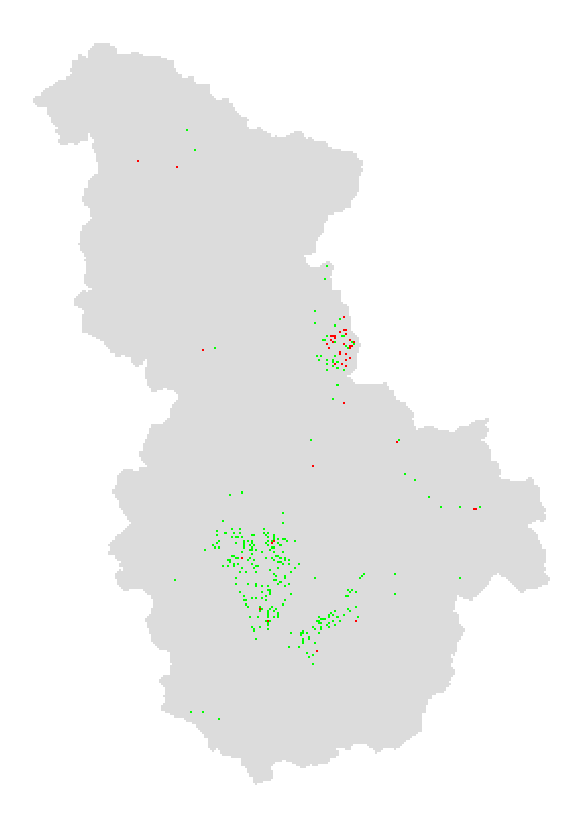

In [74]:
rf_sum = sejong.copy()
rf_sum['FP'] = [0]*len(rf_sum)
for i in idx:
    rf_sum['FP'] += rf_df[i]['FP']
print('RandomForest 모델들이 중복 추천한 격자 수 :', len(rf_sum[rf_sum['FP']>2]))

fig, ax1 = plt.subplots(figsize=(15, 15))
fig.set_facecolor('white')
sejong['geometry'].plot(ax=ax1, color='gainsboro')
sejong[sejong['EV']==1].plot(ax=ax1, column='EV', color='lime', aspect=1)
rf_sum[rf_sum['FP']>2].plot(ax=ax1, color='red', aspect=1)
ax1.set_axis_off()
plt.show()

In [30]:
rf_clf[4].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': 'sqrt',
 'max_leaf_nodes': 69,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 126,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

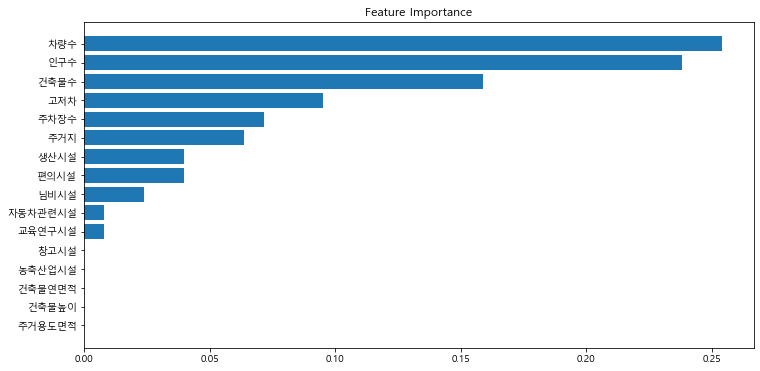

In [31]:
params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': 'sqrt',
 'max_leaf_nodes': 69,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 126,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

clf = ensemble.RandomForestClassifier(**params)
clf.fit(train_data_rus, train_target_rus)
proba = clf.predict_proba(test_data)
preds = (proba[:,1] >= 0.5).astype('int')
feature_importance(clf)

### LightGBM

In [273]:
print(lgbm_F1)
print(lgbm_TP)
print(lgbm_FP)
lgbm_result = pd.DataFrame({'F1_score':lgbm_F1,
                            'TP':lgbm_TP,
                            'FP':lgbm_FP})
lgbm_result

[0.4057377049180328, 0.3841698841698842, 0.39585492227979274, 0.5172413793103448, 0.6040268456375839, 0.44685990338164255, 0.4386174016686532, 0.38906414300736075, 0.42630385487528344, 0.43337819650067294, 0.44592790387182907, 0.4475920679886685, 0.4396200814111262, 0.6308068459657702, 0.46476761619190404, 0.43665768194070076, 0.4387755102040817, 0.5112262521588947]
[198, 199, 191, 150, 135, 185, 184, 185, 188, 161, 167, 158, 162, 129, 155, 162, 172, 148]
[502, 561, 498, 154, 36, 367, 379, 490, 418, 306, 306, 272, 299, 4, 236, 304, 336, 155]


F1_score   TP   FN
0   0.405738  198  502
1   0.384170  199  561
2   0.395855  191  498
3   0.517241  150  154
4   0.604027  135   36
5   0.446860  185  367
6   0.438617  184  379
7   0.389064  185  490
8   0.426304  188  418
9   0.433378  161  306
10  0.445928  167  306
11  0.447592  158  272
12  0.439620  162  299
13  0.630807  129    4
14  0.464768  155  236
15  0.436658  162  304
16  0.438776  172  336
17  0.511226  148  155

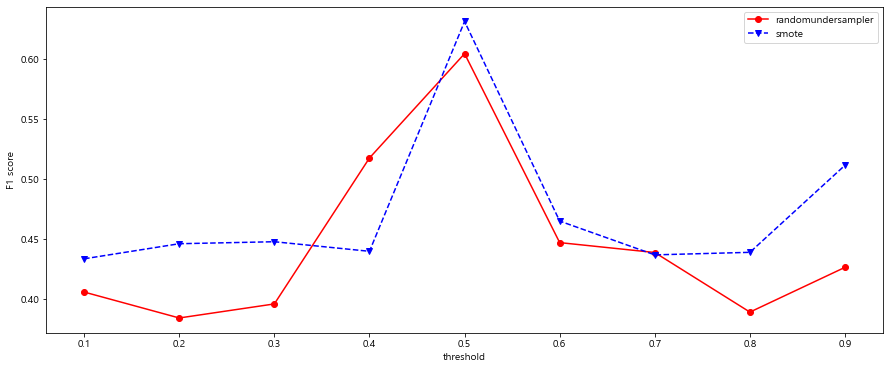

In [274]:
threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.figure(figsize=(15, 6))
plt.plot(threshold, lgbm_result['F1_score'][:9].to_list(), 'ro-', threshold, lgbm_result['F1_score'][9:].to_list(), 'bv--')
plt.legend(['randomundersampler', 'smote'])
plt.xlabel('threshold')
plt.ylabel('F1 score')
plt.show()

In [23]:
print('3번째 모델')
arrange(lgbm_df[3])

print('\n4번째 모델')
arrange(lgbm_df[4])

print('\n13번째 모델')
arrange(lgbm_df[13])

print('\n17번째 모델')
arrange(lgbm_df[17])

3번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 304
recall score 실제 충전소가 맞는 지 맞춘 경우 : 150 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 46966 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 154 / 47120

4번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 171
recall score 실제 충전소가 맞는 지 맞춘 경우 : 135 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47084 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 36 / 47120

13번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 133
recall score 실제 충전소가 맞는 지 맞춘 경우 : 129 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47116 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 4 / 47120

17번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 303
recall score 실제 충전소가 맞는 지 맞춘 경우 : 148 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 46965 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 155 / 47120


LightGBM 모델들이 중복 추천한 격자 수 : 29


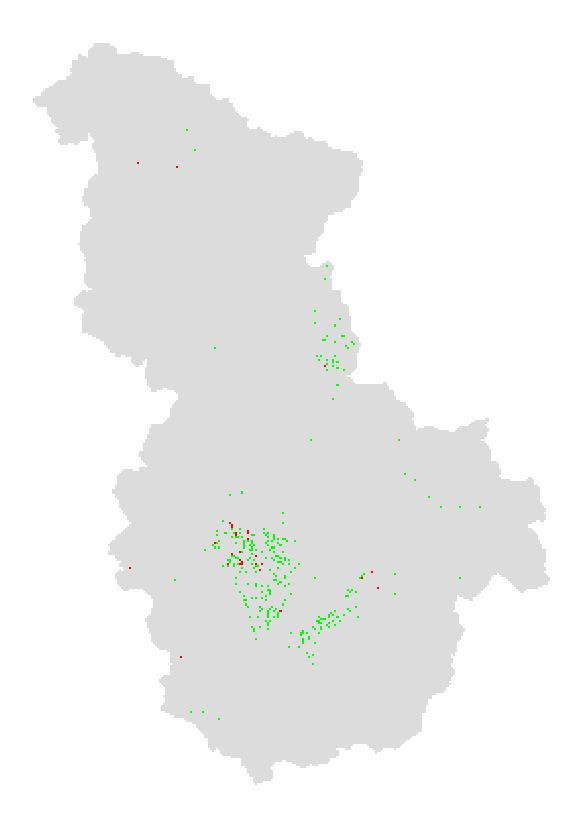

In [30]:
lgbm_sum = sejong.copy()
lgbm_sum['FP'] = lgbm_df[3]['FP'] + lgbm_df[4]['FP'] + lgbm_df[13]['FP'] + lgbm_df[17]['FP']

print('LightGBM 모델들이 중복 추천한 격자 수 :', len(lgbm_sum[lgbm_sum['FP']>2]))
fig, ax1 = plt.subplots(figsize=(15, 15))
fig.set_facecolor('white')
sejong['geometry'].plot(ax=ax1, color='gainsboro')
sejong[sejong['EV']==1].plot(ax=ax1, column='EV', color='lime', aspect=1)
lgbm_sum[lgbm_sum['FP']>2].plot(ax=ax1, color='red', aspect=1)
ax1.set_axis_off()
plt.show()

In [31]:
lgbm_clf[4].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.649805253699943,
 'importance_type': 'split',
 'learning_rate': 0.0001324457034893535,
 'max_depth': 9,
 'min_child_samples': 20,
 'min_child_weight': 8,
 'min_split_gain': 0.0,
 'n_estimators': 4800,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.5968297802559932,
 'reg_lambda': 0.11582887397582241,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'colsample_bylevel': 0.7916400635068106,
 'colsample_bynode': 0.8833222413319739,
 'gamma': 0.559424285340915}

[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: gamma


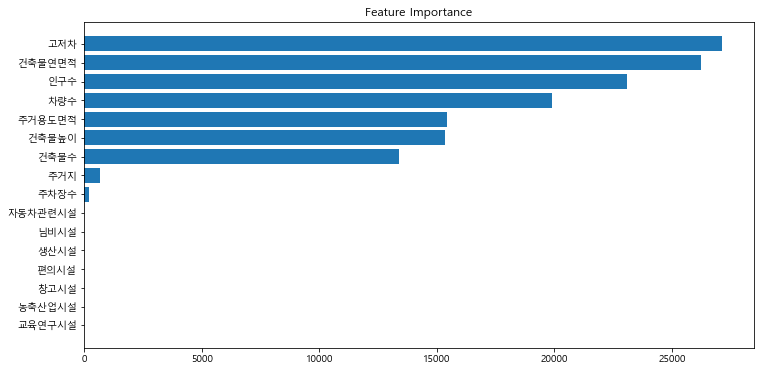

In [33]:
params = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.649805253699943,
 'importance_type': 'split',
 'learning_rate': 0.0001324457034893535,
 'max_depth': 9,
 'min_child_samples': 20,
 'min_child_weight': 8,
 'min_split_gain': 0.0,
 'n_estimators': 4800,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.5968297802559932,
 'reg_lambda': 0.11582887397582241,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'colsample_bylevel': 0.7916400635068106,
 'colsample_bynode': 0.8833222413319739,
 'gamma': 0.559424285340915}

clf = lightgbm.LGBMClassifier(**params)
clf.fit(train_data_rus, train_target_rus, verbose=0)
proba = clf.predict_proba(test_data)
preds = (proba[:,1] >= 0.5).astype('int')
feature_importance(clf)

### CatBoost

In [45]:
print(catb_F1)
print(catb_TP)
print(catb_FP)
catb_result = pd.DataFrame({'F1_score':catb_F1,
                            'TP':catb_TP,
                            'FP':catb_FP})
catb_result

[0.6114942528735633, 0.6104783599088838, 0.6049661399548533, 0.6059225512528473, 0.6336633663366337, 0.5929203539823008, 0.6063348416289592, 0.6031746031746031, 0.5968819599109131, 0.5261261261261262, 0.5437262357414449, 0.5433962264150943, 0.5952890792291221, 0.6143187066974596, 0.552, 0.6031746031746031, 0.6063348416289592, 0.600451467268623]
[133, 134, 134, 133, 128, 134, 134, 133, 134, 146, 143, 144, 139, 133, 138, 133, 134, 133]
[26, 29, 33, 30, 0, 42, 32, 32, 39, 133, 107, 110, 52, 24, 86, 32, 32, 34]


F1_score   TP   FP
0   0.611494  133   26
1   0.610478  134   29
2   0.604966  134   33
3   0.605923  133   30
4   0.633663  128    0
5   0.592920  134   42
6   0.606335  134   32
7   0.603175  133   32
8   0.596882  134   39
9   0.526126  146  133
10  0.543726  143  107
11  0.543396  144  110
12  0.595289  139   52
13  0.614319  133   24
14  0.552000  138   86
15  0.603175  133   32
16  0.606335  134   32
17  0.600451  133   34

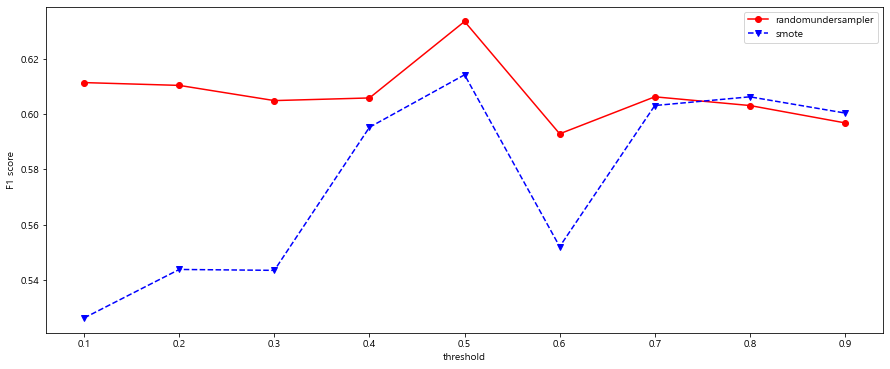

In [46]:
threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.figure(figsize=(15, 6))
plt.plot(threshold, catb_result['F1_score'][:9].to_list(), 'ro-', threshold, catb_result['F1_score'][9:].to_list(), 'bv--')
plt.legend(['randomundersampler', 'smote'])
plt.xlabel('threshold')
plt.ylabel('F1 score')
plt.show()

In [49]:
idx = [0, 1, 2, 3, 5, 6, 7, 8, 12, 13, 15, 16, 17]

for i in idx:
    print('\n', i, '번째 모델')
    arrange(rf_df[i])


 0 번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 167
recall score 실제 충전소가 맞는 지 맞춘 경우 : 132 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47085 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 35 / 47120

 1 번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 171
recall score 실제 충전소가 맞는 지 맞춘 경우 : 132 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47081 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 39 / 47120

 2 번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 158
recall score 실제 충전소가 맞는 지 맞춘 경우 : 132 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47094 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 26 / 47120

 3 번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 165
recall score 실제 충전소가 맞는 지 맞춘 경우 : 132 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47087 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 33 / 47120

 5 번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 162
recall score 실제 충전소가 맞는 지 맞춘 경우 : 132 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47090 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 30 / 47120

 6 번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류

catboost 모델들이 중복 추천한 격자 수 : 44


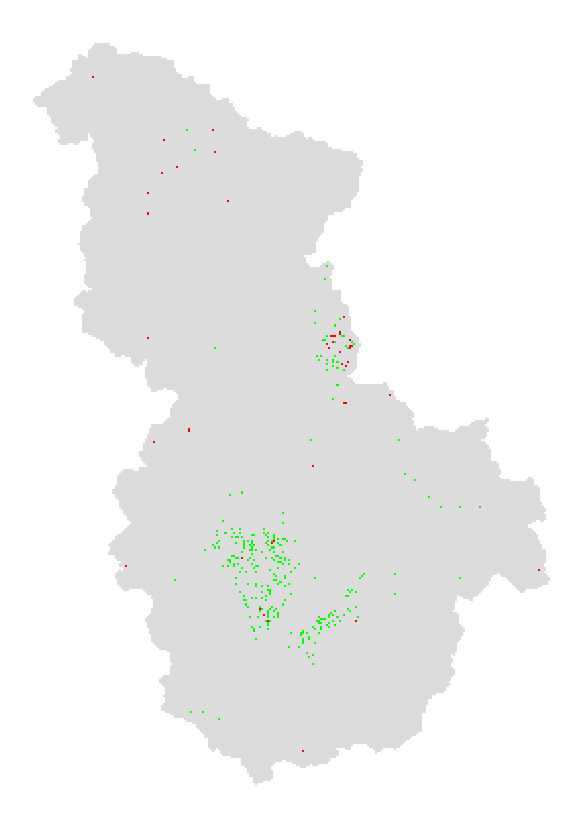

In [81]:
catb_sum = sejong.copy()
catb_sum['FP'] = [0]*len(catb_sum)
for i in idx:
    catb_sum['FP'] += catb_df[i]['FP']

print('catboost 모델들이 중복 추천한 격자 수 :', len(catb_sum[catb_sum['FP']>2]))
fig, ax1 = plt.subplots(figsize=(15, 15))
fig.set_facecolor('white')
sejong['geometry'].plot(ax=ax1, color='gainsboro')
sejong[sejong['EV']==1].plot(ax=ax1, column='EV', color='lime', aspect=1)
catb_sum[catb_sum['FP']>2].plot(ax=ax1, color='red', aspect=1)
ax1.set_axis_off()
plt.show()

In [48]:
catb_clf[4].get_params()

{'depth': 1,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'colsample_bylevel': 0.010282968974196553}

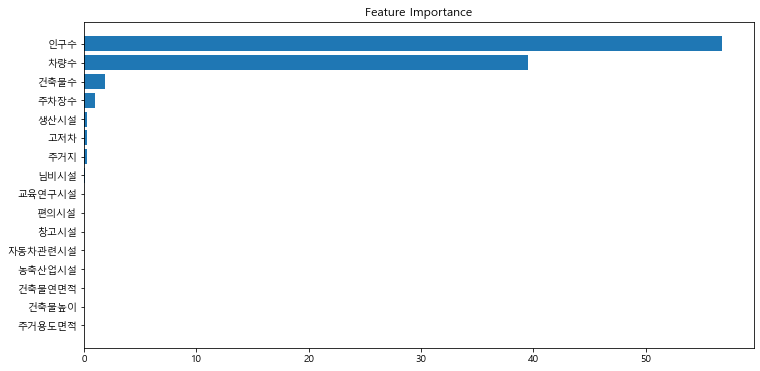

In [47]:
params = {'depth': 1,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'colsample_bylevel': 0.010282968974196553}

clf = catboost.CatBoostClassifier(**params)
clf.fit(train_data_rus, train_target_rus, verbose=0, early_stopping_rounds=100)
proba = clf.predict_proba(test_data)
preds = (proba[:,1] >= 0.6).astype('int')
feature_importance(clf)

### 결과 결합

In [19]:
rf_sum = pd.read_csv('./dataset/전처리후/rf_result.csv', encoding='cp949')
lgbm_sum = pd.read_csv('./dataset/전처리후/lgbm_result.csv', encoding='cp949')
catb_sum = pd.read_csv('./dataset/전처리후/catb_result.csv', encoding='cp949')

In [20]:
idx = rf_sum[rf_sum['FP']>2].index
rf_sum['rf_FP_dup'] = [0]*len(rf_sum)
for i in idx:
    rf_sum['rf_FP_dup'].loc[i] = 1
print(len(rf_sum[rf_sum['rf_FP_dup']==1]))

idx = lgbm_sum[lgbm_sum['FP']>2].index
lgbm_sum['lgbm_FP_dup'] = [0]*len(lgbm_sum)
for i in idx:
    lgbm_sum['lgbm_FP_dup'].loc[i] = 1
print(len(lgbm_sum[lgbm_sum['lgbm_FP_dup']==1]))

idx = catb_sum[catb_sum['FP']>2].index
catb_sum['catb_FP_dup'] = [0]*len(catb_sum)
for i in idx:
    catb_sum['catb_FP_dup'].loc[i] = 1
print(len(catb_sum[catb_sum['catb_FP_dup']==1]))

44
29
25


In [21]:
result = sejong.copy()
result['rf_FP_dup'] = rf_sum['rf_FP_dup']
result['lgbm_FP_dup'] = lgbm_sum['lgbm_FP_dup']
result['catb_FP_dup'] = catb_sum['catb_FP_dup']
result['all_FP_dup'] = rf_sum['rf_FP_dup'] + lgbm_sum['lgbm_FP_dup'] + catb_sum['catb_FP_dup']

In [22]:
print('세 모델 중 한 모델이상 추천한 곳 :', len(result[result['all_FP_dup']>=1]))
print('세 모델 중 두 모델이상 추천한 곳 :', len(result[result['all_FP_dup']>=2]))
print('세 모델 중 세 모델이상 추천한 곳 :', len(result[result['all_FP_dup']>=3]))

세 모델 중 한 모델이상 추천한 곳 : 78
세 모델 중 두 모델이상 추천한 곳 : 18
세 모델 중 세 모델이상 추천한 곳 : 2


In [23]:
result['one_model_select'] = [0] * len(result)
result['two_model_select'] = [0] * len(result)
result['three_model_select'] = [0] * len(result)

idx = result[result['all_FP_dup']>=1].index
for i in idx:
    result['one_model_select'].loc[i] = 1
    
idx = result[result['all_FP_dup']>=2].index
for i in idx:
    result['two_model_select'].loc[i] = 1
    
idx = result[result['all_FP_dup']>=3].index
for i in idx:
    result['three_model_select'].loc[i] = 1

### 전기차 충전소 최적 입지 선정 결과

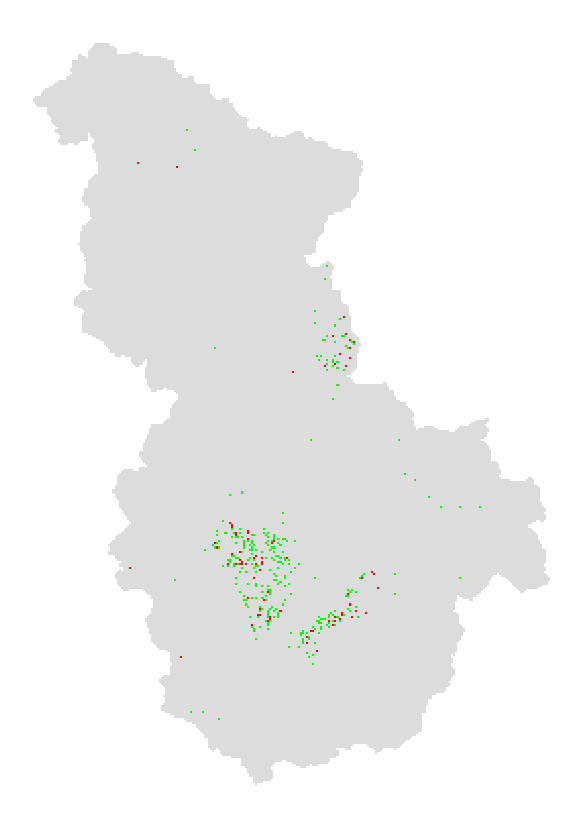

In [28]:
## 하나의 모델만 선택한 경우, 78
map_visualization(result[result.columns[:-2]])

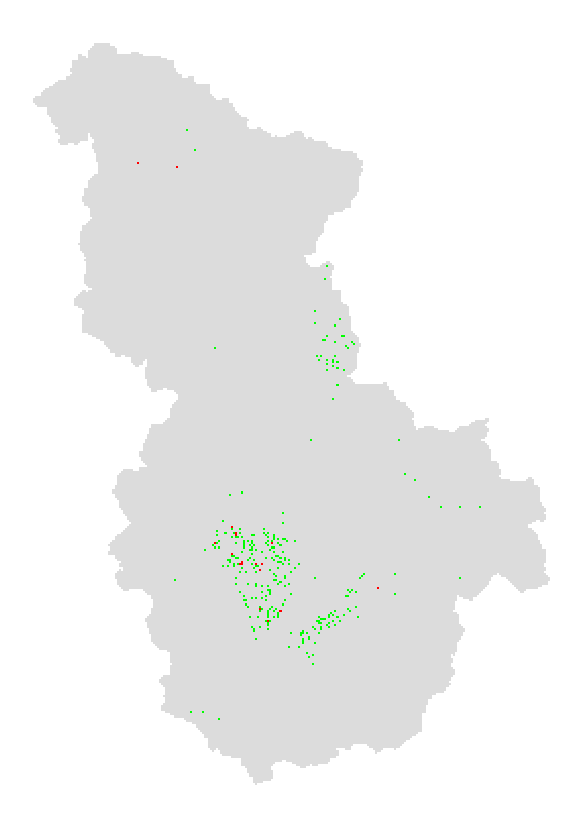

In [29]:
## 두 개의 모델이 선택한 경우, 18
map_visualization(result[result.columns[:-1]])

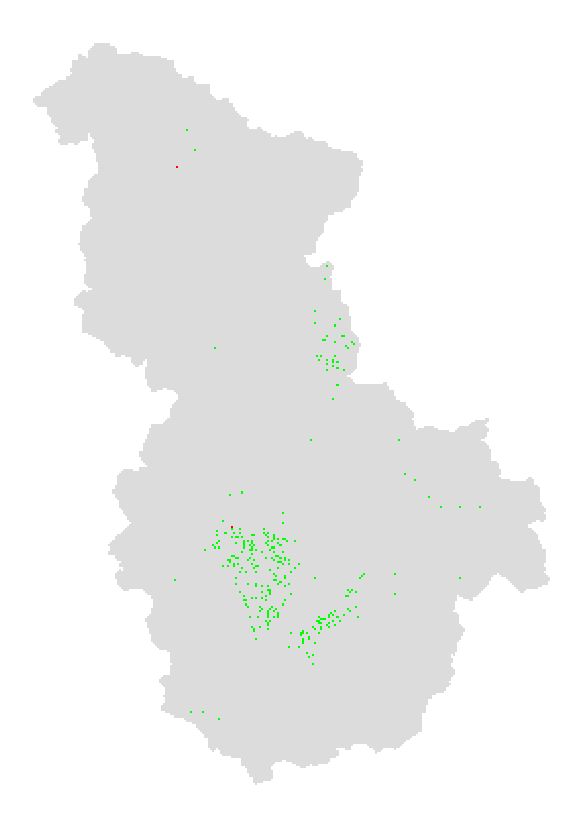

In [30]:
## 세 개의 모델이 선택한 경우, 2
map_visualization(result)

In [31]:
result = result[['geometry', 'lat', 'lng', '고저차', '인구수', '건축물수', '차량수', '주거용도면적',
       '건축물높이', '건축물연면적', '주차장수', '교육연구시설', '주거지', '농축산업시설', '창고시설', '편의시설',
       '생산시설', '님비시설', '자동차관련시설', 'EV', 'rf_FP_dup', 'lgbm_FP_dup',
       'catb_FP_dup', 'one_model_select', 'two_model_select',
       'three_model_select']]

result.to_csv('./dataset/전처리후/세종시_전기차_최적입지선정.csv', encoding='cp949')

In [32]:
result = pd.read_csv('./dataset/전처리후/세종시_전기차_최적입지선정.csv', encoding='cp949')

### 지도 시각화

In [3]:
geo = geopandas.read_file('./dataset/전처리전/전국_읍면동_경계.geojson', encoding='utf-8')
geo = geo[geo['sidonm'] == '세종특별자치시']
geo['color'] = [0]*22

In [98]:
m = folium.Map(location=(36.57026017312205, 127.26846706447992), zoom_start=11)
    
heatMap = HeatMap(zip(result['lat'], result['lng'], result['인구수']),
                min_opacity=0.05,
                max_val=5,
                radius=5, blur=3,
                max_zoom=10,color='red')

m.add_child(heatMap)
#m.save('heatmap_세종_인구수.html')
m

### 기존 충전소 위치

In [37]:
# Draw a basemap
m = folium.Map(location=(36.57026017312205, 127.26846706447992), tiles='cartodbpositron', zoom_start=11)

folium.GeoJson(geo, name = 'json_data').add_to(m)

# Add  points to the map

mc = MarkerCluster()
for i in result[result['EV']==1].index:
    mc.add_child(    
        Marker(location = [result.loc[i]['lat'], result.loc[i]['lng']])
    )
    
m.add_child(mc)

# Display the map
m
#m.save('현재_설치된_충전소_위치.html')

### 모델별 입지 시각화

In [107]:
# Draw a basemap
m = folium.Map(location=(36.57026017312205, 127.26846706447992), tiles='cartodbpositron', zoom_start=11)

folium.GeoJson(geo, name = 'json_data').add_to(m)

# Add  points to the map

mc = MarkerCluster()
for i in result[result['catb_FP_dup']==1].index:
    mc.add_child(    
        Marker(location = [result.loc[i]['lat'], result.loc[i]['lng']])
    )
    
m.add_child(mc)

# Display the map
m
#m.save('CatBoost_결과.html')

### 최적 입지 마커클러스터

In [42]:
# Draw a basemap
m = folium.Map(location=(36.57026017312205, 127.26846706447992), tiles='cartodbpositron', zoom_start=11)

folium.GeoJson(geo, name = 'json_data').add_to(m)

# Add  points to the map
mc = MarkerCluster()
for i in result[result['one_model_select']==1].index:
    mc.add_child(    
        Marker(location = [result.loc[i]['lat'], result.loc[i]['lng']],
              icon=folium.Icon(color='blue', icon='thumbs-up', prefix='fa'))
    )
    
m.add_child(mc)
# Display the map
m
#m.save('최적입지만 출력.html')

### 최적 입지와 현재 충전소 위치 비교

In [40]:
# Draw a basemap
m = folium.Map(location=(36.57026017312205, 127.26846706447992), tiles='cartodbpositron', zoom_start=11)

folium.GeoJson(geo, name = 'json_data').add_to(m)

# Add  points to the map
mc = MarkerCluster()
for i in result[result['one_model_select']==1].index:
    mc.add_child(    
        Marker(location = [result.loc[i]['lat'], result.loc[i]['lng']],
              icon=folium.Icon(color='blue', icon='thumbs-up', prefix='fa'))
    )
    
m.add_child(mc)

mc = MarkerCluster()
for i in result[result['EV']==1].index:
    mc.add_child(    
        Marker(location = [result.loc[i]['lat'], result.loc[i]['lng']],
              icon=folium.Icon(color='red', icon='flash', prefix='fa'))
    )
    
m.add_child(mc)

# Display the map
m
#m.save('현_충전소와_최적입지_비교.html')

### Pydeck 3D 시각화

#### 정규화 및 좌표계 변경

In [149]:
sejong_scaling = sejong.copy()
sejong_scaling_minmax = scaler.fit_transform(sejong[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']])
sejong_scaling_minmax = pd.DataFrame(sejong_scaling_minmax, columns=['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차'])
sejong_scaling[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']] = sejong_scaling_minmax

In [180]:
geometry = sejong_scaling['geometry'].astype(str)

length_100m = (36.73376199366808 - 36.40675835257603) / 364
width_100m = (127.4092754044858 - 127.12765872447403) / 254

co = []

for g in geometry:
    temp1 = []
    for t in g.split('((')[1].split('))')[0].split(', '):
        temp2 = []
        temp2.append((int(t.split()[0]) - 966700) / 100 * width_100m + 127.12765872447403)
        temp2.append((int(t.split()[1]) - 1823200) / 100 * length_100m + 36.40675835257603)
        temp1.append(temp2)
    co.append(temp1)

sejong_scaling['coordinates'] = co

#### pydeck params

In [189]:
view_state = pydeck.ViewState(
    latitude=36.57026017312205,
    longitude=127.26846706447992,
    zoom=11,
    max_zoom=20,
    pitch=45,
    bearing=0)

In [236]:
layer = pydeck.Layer(
    'PolygonLayer',
    sejong_scaling[sejong_scaling['인구수정규화']>0],
    get_polygon='coordinates',
    #get_position='[lng, lat]',
    auto_highlight=True,
    elevation_scale=5000,
    #elevation_range=[0, 3000],
    pickable=True,
    #get_fill_color='[0, 255*인구수정규화, 0]',
    get_fill_color='[200, 100, 150, 140]',
    extruded = True,
    get_elevation = '인구수정규화',
)

In [238]:
r = pydeck.Deck(
    map_style='light',
    layers=layer,
    initial_view_state=view_state)

r
#r.to_html('./시각화/pydeck_인구수.html')

### column corr heatmap 상관관계 시각화

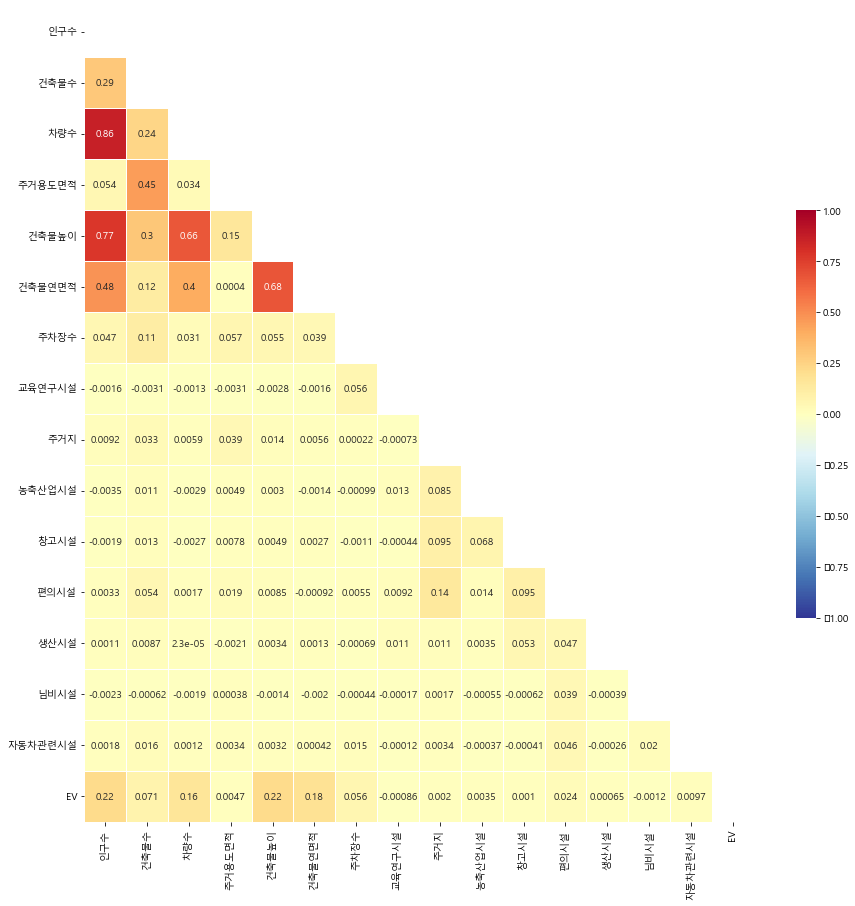

In [246]:
df = sejong[sejong.columns[3:]].corr()

fig, ax = plt.subplots( figsize=(15,15) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(df, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

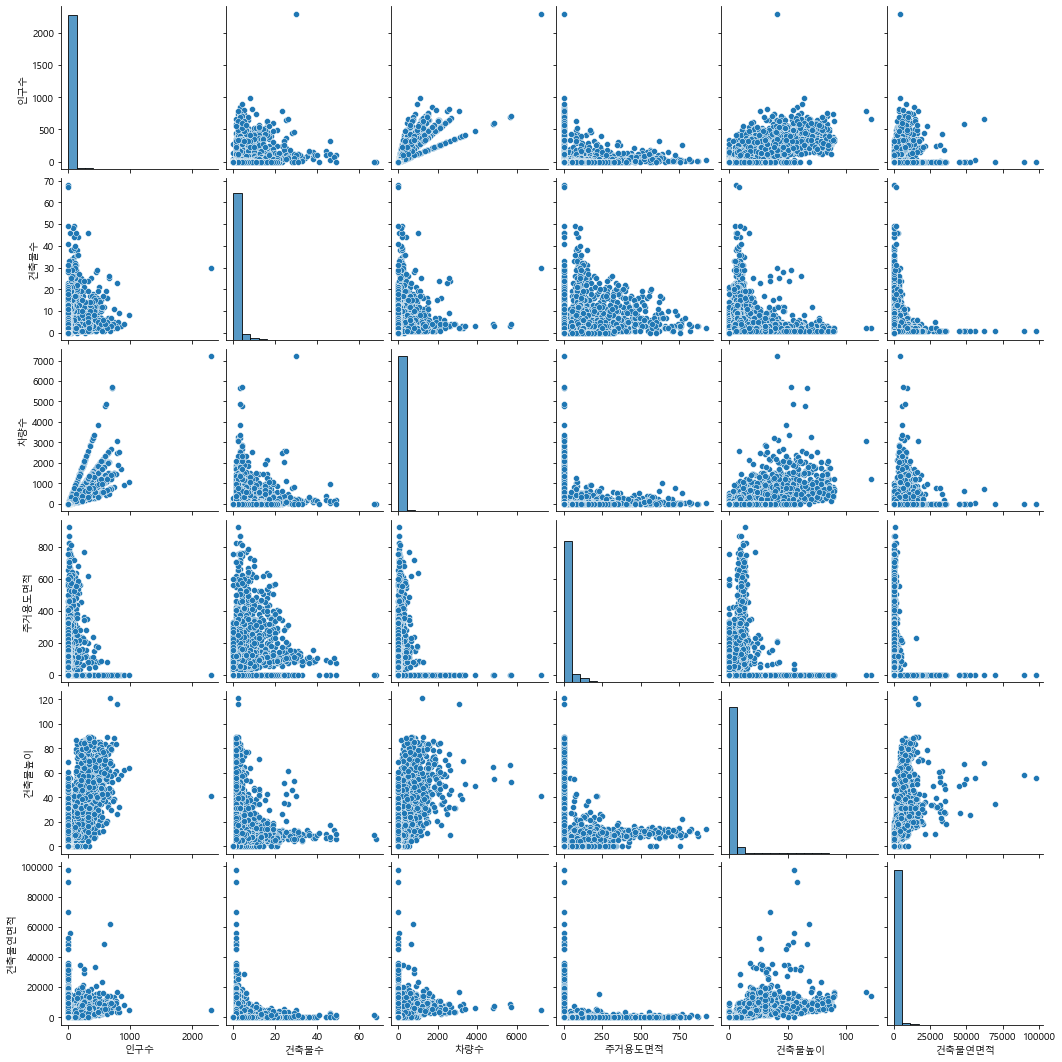

In [249]:
sns.pairplot(sejong[sejong.columns[3:10]])
plt.show()